LOAD PICKLE MODEL


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## DATA PRE-PROCESSING

# =========================
# 0) Mount Drive
# =========================
from google.colab import drive
drive.mount("/content/drive")

import os
import numpy as np
import pandas as pd
import pickle

# =========================
# 1) Paths
# =========================
BASE_DIR = "/content/drive/My Drive/Bayesian Statistics/BS Project/Codes"

MODEL_PKL = os.path.join(BASE_DIR, "Model_7.pkl")

# Set path
DATA_CSV = os.path.join(BASE_DIR, "df_reduced.csv")
DATA_PKL = None
DATA_XLSX = None
XLSX_SHEET = 0

# =========================
# 2) Load dataset
# =========================
if DATA_PKL is not None:
    df = pd.read_pickle(DATA_PKL)
elif DATA_CSV is not None:
    df = pd.read_csv(DATA_CSV)
elif DATA_XLSX is not None:
    df = pd.read_excel(DATA_XLSX, sheet_name=XLSX_SHEET)
else:
    raise ValueError("Please set DATA_CSV or DATA_PKL or DATA_XLSX to a valid file.")

print("Loaded df:", df.shape)
display(df.head())

# =========================
# 3) Recreate model matrices
# =========================
ID_COL = "CAI"
ADD_INTERCEPT = False

target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
covariate_cols = df.columns.drop(list(target_list) + [ID_COL])

cols_needed = [ID_COL] + target_list + list(covariate_cols)
df_model = df[cols_needed].dropna().copy()

Y_mat = df_model[target_list].to_numpy(dtype=float)
N, K = Y_mat.shape

X_mat = df_model[covariate_cols].to_numpy(dtype=float)
_, P = X_mat.shape

donor_ids, id_index = np.unique(df_model[ID_COL].to_numpy(), return_inverse=True)
I = len(donor_ids)
id_stan = id_index + 1

print(f"N={N}, K={K}, P={P}, I={I}")
print("Targets:", target_list)
print("Num covariates:", len(covariate_cols))

# =========================
# 4) Load fitted model object
# =========================
with open(MODEL_PKL, "rb") as f:
    fit = pickle.load(f)

print("Loaded fit type:", type(fit))

# =========================
# 5) Sanity checks
# =========================
needed_vars = {"beta", "Y_rep", "mu", "log_lik"}
available_vars = set(fit.stan_variables().keys())

print("Available vars (subset):", sorted(list(available_vars))[:20], "...")
missing = needed_vars - available_vars
if missing:
    raise RuntimeError(f"Fit is missing required variables: {missing}")
else:
    print("✅ Fit contains all required variables for interpretation.")

# Shape check
beta = fit.stan_variable("beta")
Y_rep = fit.stan_variable("Y_rep")
mu = fit.stan_variable("mu")

print("beta shape:", beta.shape)
print("Y_rep shape:", Y_rep.shape)
print("mu shape:", mu.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded df: (1021, 19)


,CAI,Trigliceridi,Colesterolo_Hdl,Glucosio,PMAX,BMI,Alanina_aminotransferasi_alt,Colesterolo_totale,Distribuzione_di_volume,Ematocrito_hct,Eosinofili_perc,Leucociti_wbc,Linfociti_perc,Monociti_perc,Piastrine,Polso,Proteine_totali,Volume_medio,Eta
0,4519,4.955827,4.025352,4.454347,4.795791,3.368250,0.655108,1.287443,0.065167,-0.602229,-1.690348,-0.152185,0.306764,-1.152895,0.159159,0.808926,1.211330,-0.595016,0.393353
1,4519,4.770685,4.043051,4.382027,4.795791,3.356258,0.746647,1.612525,1.087060,-1.122513,-0.158344,0.680946,0.045461,0.315215,-0.448089,-0.050441,0.961923,-0.667364,0.431880
2,4519,4.976734,3.931826,4.394449,4.875197,3.380100,0.358642,1.612523,0.297745,-0.290052,0.643758,0.088065,1.003572,-0.254154,-0.092115,-0.354102,0.213718,-0.812066,0.497079
3,4519,4.955827,4.204693,4.382027,4.795791,3.356258,1.160206,1.139682,0.527111,-0.775656,-0.703957,1.215167,-0.680382,-2.249882,-0.133995,-0.354095,0.463127,-0.570896,0.551233
4,4519,4.890349,4.219508,4.356709,4.795791,3.391811,0.920305,1.878500,1.087069,-0.394114,-0.794180,1.872893,-1.362676,-0.536124,0.263852,-0.354103,0.712524,-0.643246,0.611583


N=1021, K=5, P=13, I=35
Targets: ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
Num covariates: 13
Loaded fit type: <class 'cmdstanpy.stanfit.mcmc.CmdStanMCMC'>
Available vars (subset): ['L_Omega_cluster', 'L_Omega_eps', 'L_Sigma', 'L_Sigma_cluster', 'Sigma_cluster', 'Sigma_eps', 'Y_rep', 'alpha', 'b', 'beta', 'log_lik', 'log_theta', 'mu', 'mu_cluster', 'tau_cluster', 'tau_eps', 'theta', 'v'] ...
✅ Fit contains all required variables for interpretation.
beta shape: (4000, 13, 5)
Y_rep shape: (4000, 1021, 5)
mu shape: (4000, 1021, 5)


In [5]:
import numpy as np

# ---------- Compute y_true and p_mets (log-scale targets) ----------

# Extract posterior predictive draws
Y_rep = fit.stan_variable("Y_rep")

# Log-thresholds for MetS criteria
THR_LOG = {
    "BMI": np.log(30.0),
    "PMAX": np.log(130.0),
    "Glucosio": np.log(100.0),
    "Trigliceridi": np.log(150.0),
    "Colesterolo_Hdl": np.log(50.0),
}

def mets_from_Y_log(Y, target_list):
    """
    Y: (N, K) array of LOG targets, columns in target_list order
    returns: (N,) int array 0/1 for MetS (>=3 criteria)
    """
    idx = {t: j for j, t in enumerate(target_list)}
    crit_bmi  = Y[:, idx["BMI"]] >  THR_LOG["BMI"]
    crit_bp   = Y[:, idx["PMAX"]] >= THR_LOG["PMAX"]
    crit_glu  = Y[:, idx["Glucosio"]] >= THR_LOG["Glucosio"]
    crit_trig = Y[:, idx["Trigliceridi"]] >= THR_LOG["Trigliceridi"]
    crit_hdl  = Y[:, idx["Colesterolo_Hdl"]] <  THR_LOG["Colesterolo_Hdl"]

    n = (crit_bmi.astype(int) + crit_bp.astype(int) +
         crit_glu.astype(int) + crit_trig.astype(int) +
         crit_hdl.astype(int))

    return (n >= 3).astype(int)

# 1) Observed labels (visit-level)
Y_obs_log = df_model[target_list].to_numpy(float)
y_true = mets_from_Y_log(Y_obs_log, target_list)

# 2) Posterior predictive probabilities (visit-level)
S, N, K = Y_rep.shape
if N != Y_obs_log.shape[0]:
    raise ValueError(f"Mismatch: Y_rep has N={N}, but df_model has N={Y_obs_log.shape[0]} rows.")

y_rep_draw = np.zeros((S, N), dtype=np.int8)
for s in range(S):
    y_rep_draw[s] = mets_from_Y_log(Y_rep[s], target_list)

p_mets = y_rep_draw.mean(axis=0)

print("MetS prevalence (observed):", y_true.mean().round(4))
print("p_mets min/median/max:", float(p_mets.min()), float(np.median(p_mets)), float(p_mets.max()))


MetS prevalence (observed): 0.143
p_mets min/median/max: 0.0 0.0765 0.9835


In [6]:
# FIXED EFFECTS

beta = fit.stan_variable("beta")

summary = []
for p, cov in enumerate(covariate_cols):
    for k, targ in enumerate(target_list):
        draws = beta[:, p, k]
        summary.append({
            "covariate": cov,
            "target": targ,
            "median": np.median(draws),
            "P_pos": (draws > 0).mean()
        })

beta_df = pd.DataFrame(summary)


In [7]:
# RANDOM EFFECTS

b = fit.stan_variable("b")

b_norm = np.linalg.norm(b, axis=2)
patient_effect_strength = b_norm.mean(axis=0)

pd.Series(patient_effect_strength).describe()


,0
count,35.000000
mean,9.609948
std,0.146399
min,9.191049
25%,9.564118
50%,9.632845
75%,9.710136
max,9.828910


In [8]:
# Data and Model Overview

print("DataFrame shape:", df_model.shape)
print("\nAll columns in df_model:")
print(list(df_model.columns))

print("\nTarget variables used in the model:")
print(target_list)

print("\nCovariates used in the model:")
print(list(covariate_cols))

print("\nNumber of covariates:", len(covariate_cols))
print("Number of targets:", len(target_list))

model_covs = set(covariate_cols)
data_covs  = set(df_model.columns) - set(target_list)

print("In model but not in dataset:", model_covs - data_covs)
print("In dataset but not in model:", data_covs - model_covs)



DataFrame shape: (1021, 19)

All columns in df_model:
['CAI', 'PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI', 'Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio', 'Eta']

Target variables used in the model:
['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']

Covariates used in the model:
['Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio', 'Eta']

Number of covariates: 13
Number of targets: 5
In model but not in dataset: set()
In dataset but not in model: {'CAI'}


# Section 1: Model Performance and Tuning

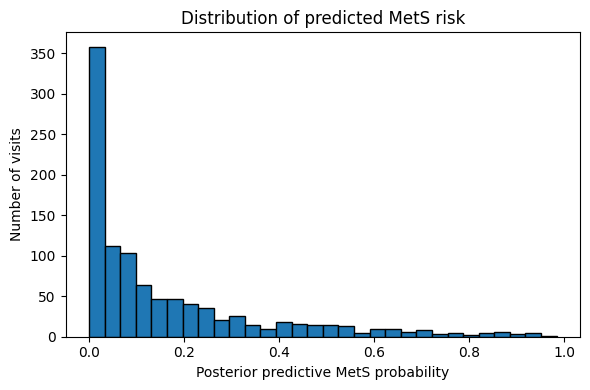

In [9]:
# ---------- 1.1 Distribution of posterior predictive MetS risk ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(p_mets, bins=30, edgecolor="black")
plt.xlabel("Posterior predictive MetS probability")
plt.ylabel("Number of visits")
plt.title("Distribution of predicted MetS risk")
plt.tight_layout()
plt.show()


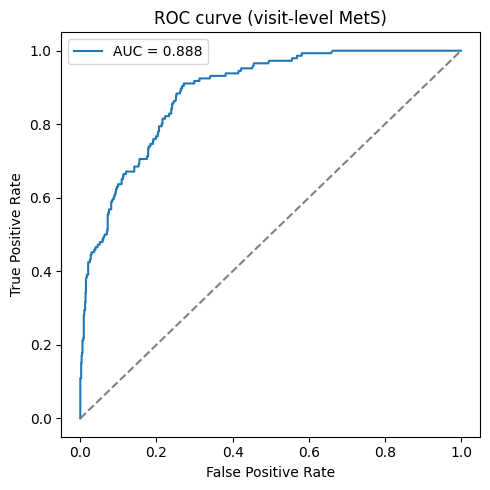

In [10]:
# ---------- 1.2 ROC curve (visit-level MetS) ----------
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_true, p_mets)
auc = roc_auc_score(y_true, p_mets)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (visit-level MetS)")
plt.legend()
plt.tight_layout()
plt.show()


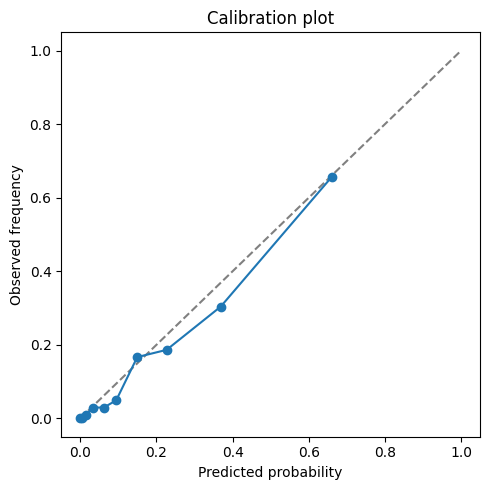

,p_mean,y_mean,n
bin,,,
"(-0.001, 0.00025]",0.000061,0.000000,111
"(0.00025, 0.00925]",0.004503,0.000000,95
"(0.00925, 0.021]",0.014829,0.009901,101
"(0.021, 0.0462]",0.033304,0.029412,102
"(0.0462, 0.0765]",0.061833,0.029412,102
"(0.0765, 0.114]",0.094348,0.049020,102
"(0.114, 0.186]",0.149642,0.166667,102
"(0.186, 0.276]",0.226654,0.186275,102
"(0.276, 0.473]",0.368826,0.303922,102


In [11]:
# ---------- 1.3 Calibration plot ----------
def calibration_plot(y, p, bins=10):
    dfc = pd.DataFrame({"y": y, "p": p})
    dfc["bin"] = pd.qcut(dfc["p"], q=bins, duplicates="drop")
    calib = dfc.groupby("bin", observed=False).agg(
        p_mean=("p", "mean"),
        y_mean=("y", "mean"),
        n=("y", "size")
    )

    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.plot(calib["p_mean"], calib["y_mean"], marker="o")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title("Calibration plot")
    plt.tight_layout()
    plt.show()

    return calib

calib_tbl = calibration_plot(y_true, p_mets)
calib_tbl


In [12]:
# Summary of predicted risk range
print("Min / Median / Max p(MetS):",
      p_mets.min(), np.median(p_mets), p_mets.max())


Min / Median / Max p(MetS): 0.0 0.0765 0.9835


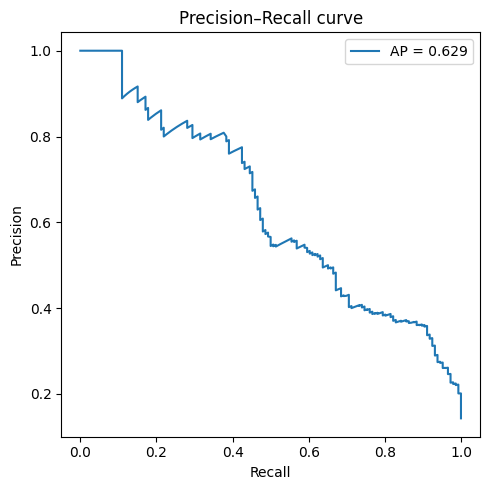

In [13]:
# ---------- 1.4 Precision–Recall curve ----------
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, p_mets)
ap = average_precision_score(y_true, p_mets)

plt.figure(figsize=(5, 5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# ---------- 1.5 Threshold tuning ----------
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.05, 0.6, 56)

rows = []
for t in thresholds:
    y_hat = (p_mets >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
        "positive_rate": y_hat.mean()
    })

thr_df = pd.DataFrame(rows)
thr_df.head()


,threshold,precision,recall,f1,positive_rate
0,0.05,0.236667,0.972603,0.380697,0.587659
1,0.06,0.250444,0.965753,0.397743,0.551420
2,0.07,0.260223,0.958904,0.409357,0.526934
3,0.08,0.275654,0.938356,0.426128,0.486778
4,0.09,0.290870,0.938356,0.444084,0.461312


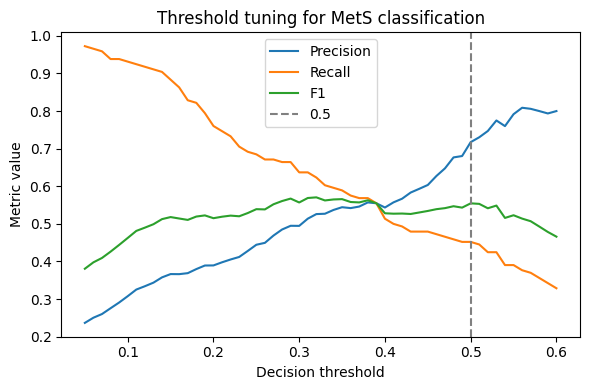

In [15]:
# ---------- 1.6 Precision/Recall/f1 tuning ------------

plt.figure(figsize=(6, 4))
plt.plot(thr_df["threshold"], thr_df["precision"], label="Precision")
plt.plot(thr_df["threshold"], thr_df["recall"], label="Recall")
plt.plot(thr_df["threshold"], thr_df["f1"], label="F1")
plt.axvline(0.5, linestyle="--", color="gray", label="0.5")
plt.xlabel("Decision threshold")
plt.ylabel("Metric value")
plt.title("Threshold tuning for MetS classification")
plt.legend()
plt.tight_layout()
plt.show()


# Section 2: Bio-Marker level interpretation

In [16]:
# ---------- 2.0 Extract beta ----------
beta = fit.stan_variable("beta")  # (S, P, K)


In [17]:
# ---------- 2.1 Build beta_df: posterior summaries of fixed effects ----------
rows = []
for p_idx, cov in enumerate(covariate_cols):
    for k_idx, targ in enumerate(target_list):
        draws = beta[:, p_idx, k_idx]
        rows.append({
            "covariate": cov,
            "target": targ,
            "median": np.median(draws),
            "q2.5": np.quantile(draws, 0.025),
            "q97.5": np.quantile(draws, 0.975),
            "P(beta > 0)": (draws > 0).mean(),
        })

beta_df = pd.DataFrame(rows)
beta_df.head()


,covariate,target,median,q2.5,q97.5,P(beta > 0)
0,Alanina_aminotransferasi_alt,PMAX,-0.001453,-0.006752,0.003910,0.30500
1,Alanina_aminotransferasi_alt,Glucosio,0.006936,-0.000267,0.014143,0.97050
2,Alanina_aminotransferasi_alt,Trigliceridi,0.026219,0.003131,0.049664,0.98675
3,Alanina_aminotransferasi_alt,Colesterolo_Hdl,0.000572,-0.007498,0.008998,0.55500
4,Alanina_aminotransferasi_alt,BMI,0.003579,0.000443,0.006660,0.98800


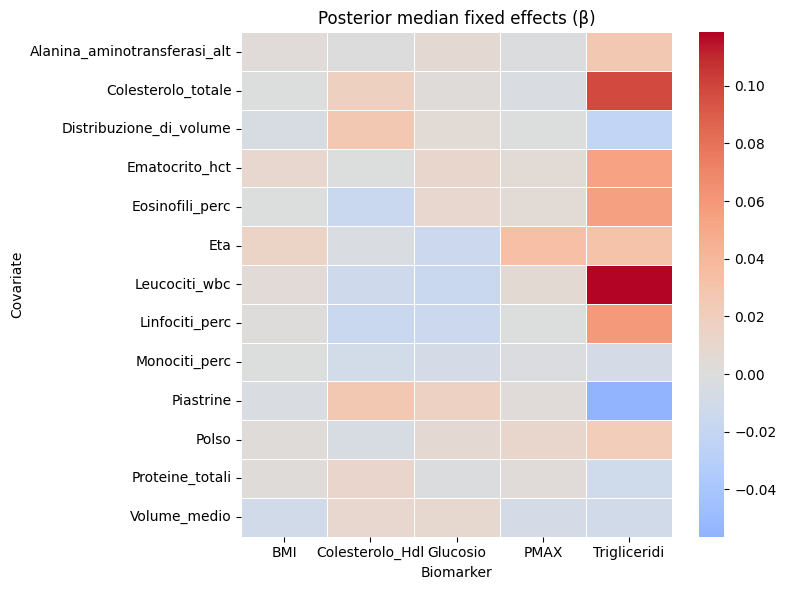

In [18]:
# ---------- 2.2 Heatmap of posterior medians (β) ----------
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_df = beta_df.pivot(index="covariate", columns="target", values="median")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Posterior median fixed effects (β)")
plt.xlabel("Biomarker")
plt.ylabel("Covariate")
plt.tight_layout()
plt.show()


In [19]:
# ---------- 2.3 Consistency score across biomarkers ----------
consistency = (
    beta_df
    .assign(
        strong_pos=lambda d: d["P(beta > 0)"] > 0.9,
        strong_neg=lambda d: d["P(beta > 0)"] < 0.1,
    )
    .assign(strong=lambda d: d["strong_pos"] | d["strong_neg"])
    .groupby("covariate")["strong"]
    .mean()
    .sort_values(ascending=False)
)

consistency


,strong
covariate,
Leucociti_wbc,1.0
Polso,1.0
Eosinofili_perc,0.8
Alanina_aminotransferasi_alt,0.6
Distribuzione_di_volume,0.6
Volume_medio,0.6
Ematocrito_hct,0.6
Linfociti_perc,0.6
Eta,0.6


In [20]:
# ---------- S2.4 Forest plot function (top 10 covariates for a target) ----------
def forest_plot_for_target(target, top_n=10):
    df_t = beta_df[beta_df["target"] == target].copy()
    df_t["abs_med"] = df_t["median"].abs()
    df_t = df_t.sort_values("abs_med", ascending=False).head(top_n)

    plt.figure(figsize=(6, 4))
    plt.errorbar(
        df_t["median"],
        df_t["covariate"],
        xerr=[
            df_t["median"] - df_t["q2.5"],
            df_t["q97.5"] - df_t["median"],
        ],
        fmt="o"
    )
    plt.axvline(0, color="gray", linestyle="--")
    plt.title(f"Top fixed effects for {target}")
    plt.xlabel("Effect size (per +1 SD covariate)")
    plt.tight_layout()
    plt.show()


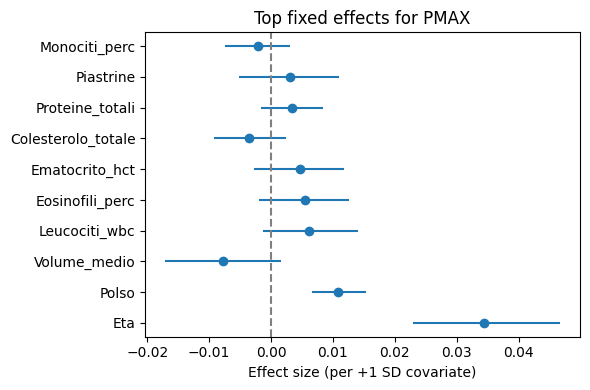

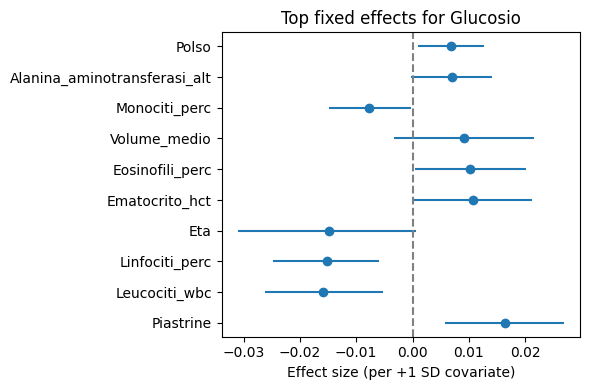

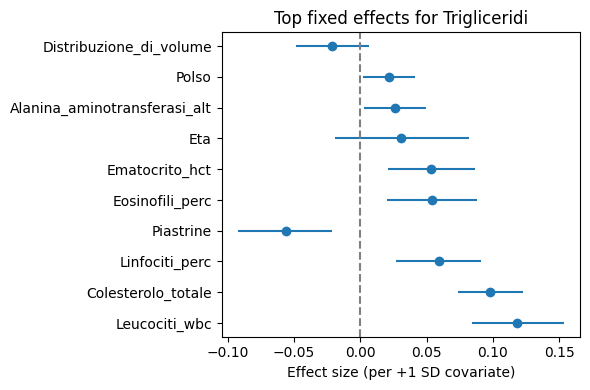

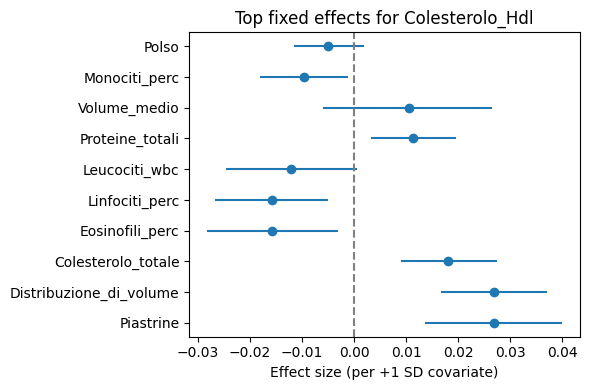

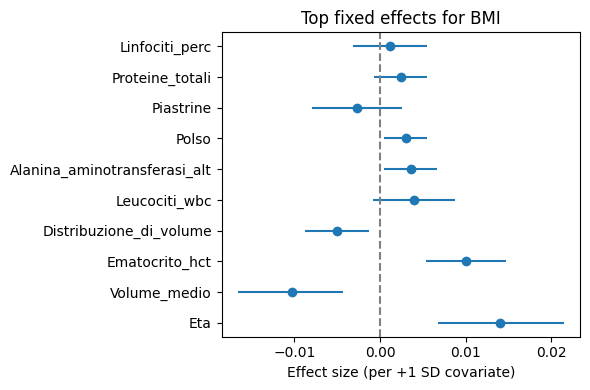

In [21]:
# ---------- S2.4b Run forest plots for all targets ----------
for targ in target_list:
    forest_plot_for_target(targ, top_n=10)


In [22]:
# ---------- S2.5 Directional consistency across biomarkers (counts) ----------
direction_rows = []

for p_idx, cov in enumerate(covariate_cols):
    pos = 0
    neg = 0
    for k_idx, targ in enumerate(target_list):
        draws = beta[:, p_idx, k_idx]
        if (draws > 0).mean() > 0.95:
            pos += 1
        if (draws < 0).mean() > 0.95:
            neg += 1
    direction_rows.append({
        "covariate": cov,
        "n_positive": pos,
        "n_negative": neg
    })

direction_df = pd.DataFrame(direction_rows)
direction_df


,covariate,n_positive,n_negative
0,Alanina_aminotransferasi_alt,3,0
1,Colesterolo_totale,2,0
2,Distribuzione_di_volume,1,1
3,Ematocrito_hct,3,0
4,Eosinofili_perc,2,1
5,Leucociti_wbc,1,2
6,Linfociti_perc,1,2
7,Monociti_perc,0,2
8,Piastrine,2,1
9,Polso,4,0


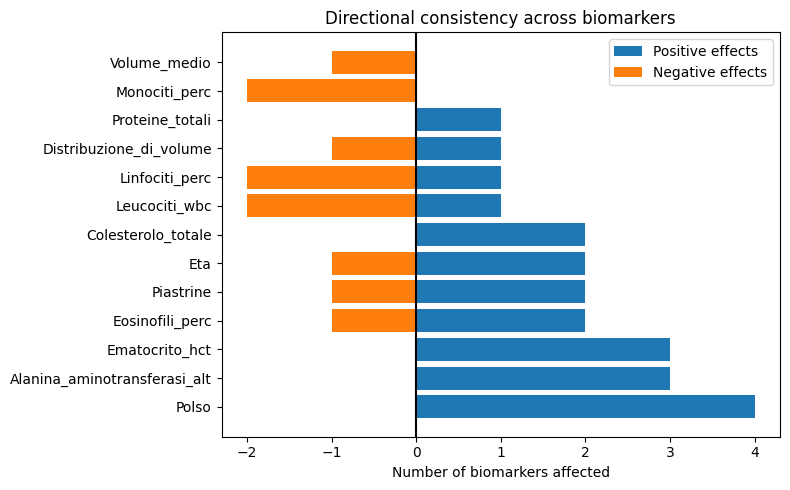

In [23]:
# ---------- S2.5b Plot directional consistency ----------
direction_df_sorted = direction_df.sort_values(
    by=["n_positive", "n_negative"], ascending=False
)

plt.figure(figsize=(8, 5))
plt.barh(direction_df_sorted["covariate"], direction_df_sorted["n_positive"], label="Positive effects")
plt.barh(direction_df_sorted["covariate"], -direction_df_sorted["n_negative"], label="Negative effects")
plt.axvline(0, color="black")
plt.xlabel("Number of biomarkers affected")
plt.title("Directional consistency across biomarkers")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# ---------- S2.6 Rank tables per target (by |median|) ----------
rank_tables = {}

for k_idx, targ in enumerate(target_list):
    r = []
    for p_idx, cov in enumerate(covariate_cols):
        draws = beta[:, p_idx, k_idx]
        med = np.median(draws)
        r.append({
            "covariate": cov,
            "median": med,
            "abs_median": abs(med),
            "P(beta>0)": (draws > 0).mean(),
        })
    rank_tables[targ] = pd.DataFrame(r).sort_values("abs_median", ascending=False)


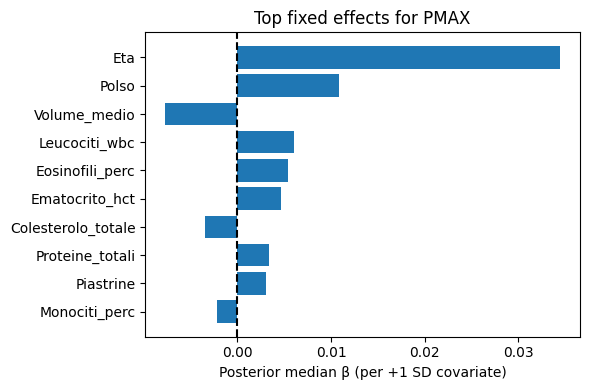

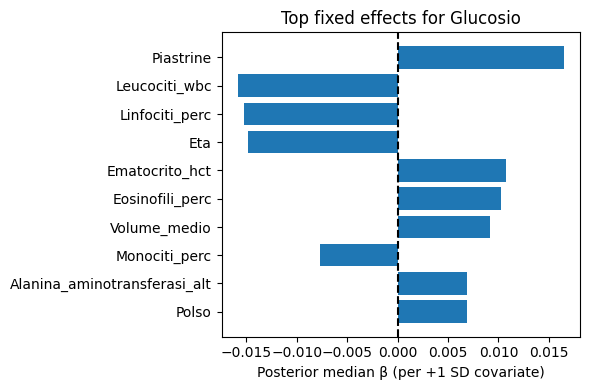

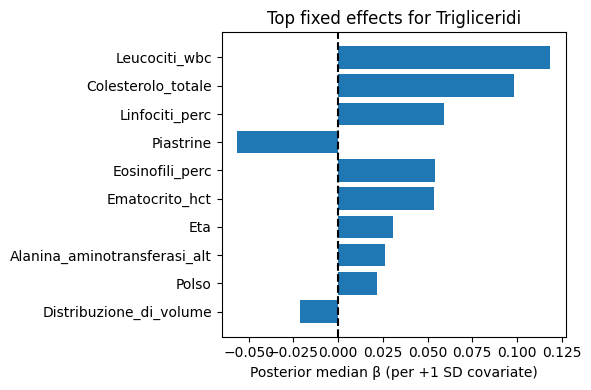

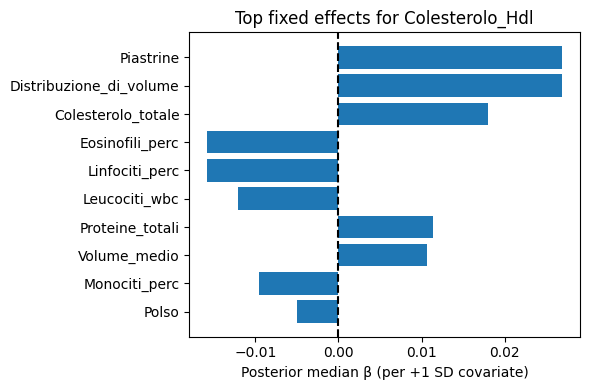

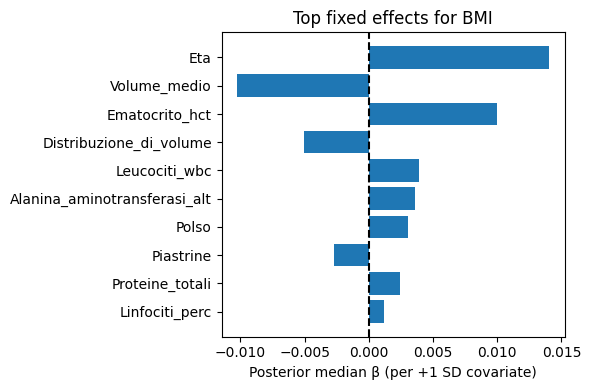

In [25]:
# ---------- S2.6b Plot top 10 per target (barh) ----------
for targ in target_list:
    top = rank_tables[targ].head(10).iloc[::-1]

    plt.figure(figsize=(6, 4))
    plt.barh(top["covariate"], top["median"])
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Posterior median β (per +1 SD covariate)")
    plt.title(f"Top fixed effects for {targ}")
    plt.tight_layout()
    plt.show()


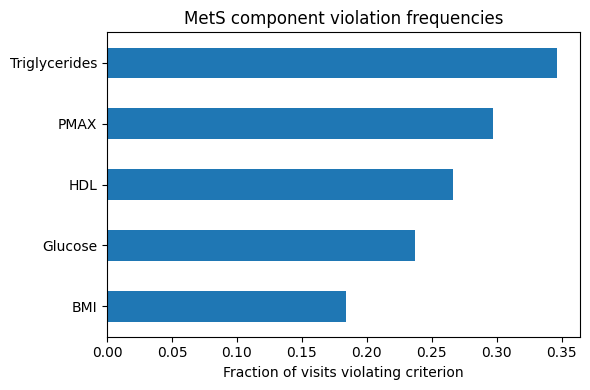

In [26]:
# ---------- S2.7 MetS component violation frequencies (targets are LOG-scale) ----------
THR_LOG = {
    "BMI": np.log(30.0),
    "PMAX": np.log(130.0),
    "Glucosio": np.log(100.0),
    "Trigliceridi": np.log(150.0),
    "Colesterolo_Hdl": np.log(50.0),
}

Y_log = df_model[target_list].to_numpy(float)

idx = {t: i for i, t in enumerate(target_list)}
violations = {
    "BMI": (Y_log[:, idx["BMI"]] > THR_LOG["BMI"]).mean(),
    "PMAX": (Y_log[:, idx["PMAX"]] >= THR_LOG["PMAX"]).mean(),
    "Glucose": (Y_log[:, idx["Glucosio"]] >= THR_LOG["Glucosio"]).mean(),
    "Triglycerides": (Y_log[:, idx["Trigliceridi"]] >= THR_LOG["Trigliceridi"]).mean(),
    "HDL": (Y_log[:, idx["Colesterolo_Hdl"]] < THR_LOG["Colesterolo_Hdl"]).mean(),
}

viol_df = pd.Series(violations).sort_values()

plt.figure(figsize=(6, 4))
viol_df.plot(kind="barh")
plt.xlabel("Fraction of visits violating criterion")
plt.title("MetS component violation frequencies")
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


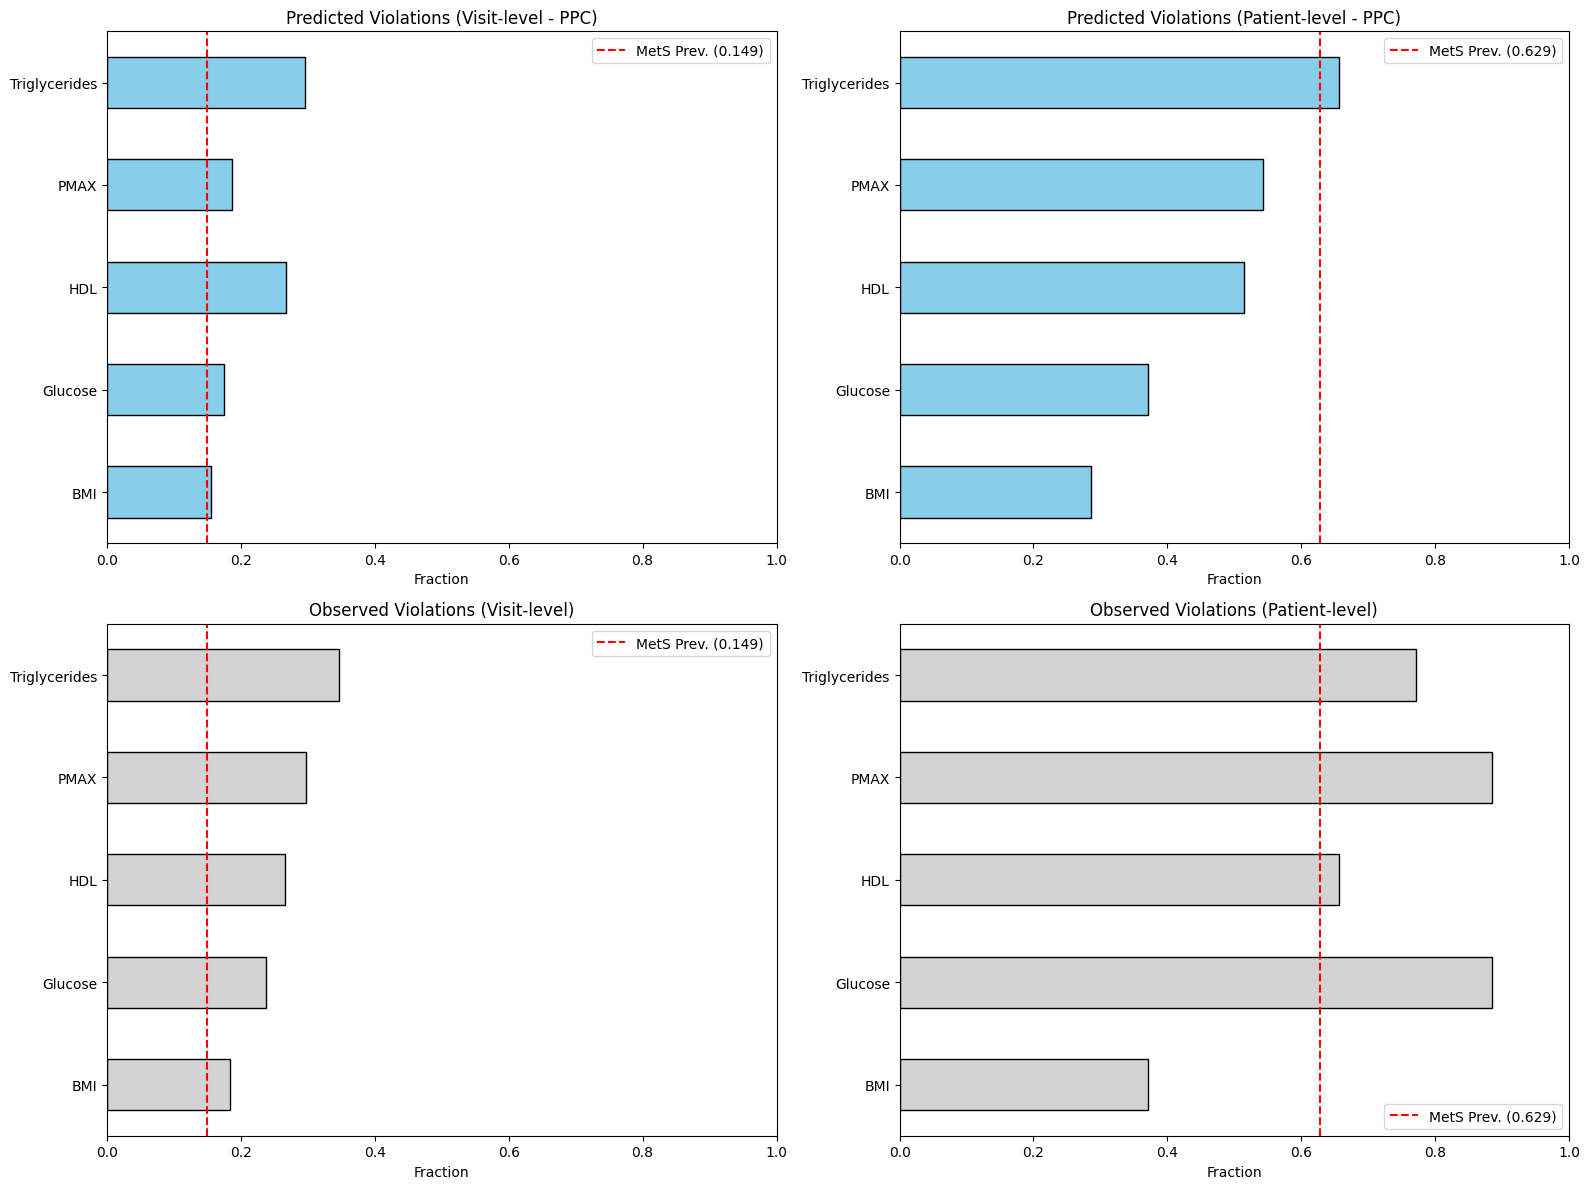

In [27]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df = pd.read_csv("/content/drive/My Drive/Bayesian Statistics/BS Project/Codes/df_balanced_reduced.csv")
with open("/content/drive/My Drive/Bayesian Statistics/BS Project/Codes/Model_7.pkl", "rb") as f:
    fit = pickle.load(f)

target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
ID_COL = "CAI"
idx = {t: i for i, t in enumerate(target_list)}

y_rep_samples = fit.stan_variable("Y_rep")
y_rep_mean = y_rep_samples.mean(axis=0)

if df['BMI'].max() < 10:
    Y_obs_log = df[target_list].to_numpy(float)
else:
    Y_obs_log = np.log(df[target_list].to_numpy(float))

THR_LOG = {
    "BMI": np.log(30.0),
    "PMAX": np.log(130.0),
    "Glucosio": np.log(100.0),
    "Trigliceridi": np.log(150.0),
    "Colesterolo_Hdl": np.log(50.0),
}

def get_v_metrics(data):
    return {
        "BMI": (data[:, idx["BMI"]] > THR_LOG["BMI"]).mean(),
        "PMAX": (data[:, idx["PMAX"]] >= THR_LOG["PMAX"]).mean(),
        "Glucose": (data[:, idx["Glucosio"]] >= THR_LOG["Glucosio"]).mean(),
        "Triglycerides": (data[:, idx["Trigliceridi"]] >= THR_LOG["Trigliceridi"]).mean(),
        "HDL": (data[:, idx["Colesterolo_Hdl"]] < THR_LOG["Colesterolo_Hdl"]).mean(),
    }

def get_p_metrics(data, ids):
    tmp = pd.DataFrame(data, columns=target_list)
    tmp[ID_COL] = ids
    return {
        "BMI": tmp.groupby(ID_COL)['BMI'].max().apply(lambda x: x > THR_LOG["BMI"]).mean(),
        "PMAX": tmp.groupby(ID_COL)['PMAX'].max().apply(lambda x: x >= THR_LOG["PMAX"]).mean(),
        "Glucose": tmp.groupby(ID_COL)['Glucosio'].max().apply(lambda x: x >= THR_LOG["Glucosio"]).mean(),
        "Triglycerides": tmp.groupby(ID_COL)['Trigliceridi'].max().apply(lambda x: x >= THR_LOG["Trigliceridi"]).mean(),
        "HDL": tmp.groupby(ID_COL)['Colesterolo_Hdl'].min().apply(lambda x: x < THR_LOG["Colesterolo_Hdl"]).mean(),
    }

v_pred_vals = get_v_metrics(y_rep_mean)
p_pred_vals = get_p_metrics(y_rep_mean, df[ID_COL].values)
v_obs_vals = get_v_metrics(Y_obs_log)
p_obs_vals = get_p_metrics(Y_obs_log, df[ID_COL].values)

order = pd.Series(v_obs_vals).sort_values().index
v_pred = pd.Series(v_pred_vals).reindex(order)
p_pred = pd.Series(p_pred_vals).reindex(order)
v_obs = pd.Series(v_obs_vals).reindex(order)
p_obs = pd.Series(p_obs_vals).reindex(order)

v_prev = 152 / 1021
p_prev = 22 / 35

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

v_pred.plot(kind="barh", ax=axes[0, 0], color="skyblue", edgecolor="black")
axes[0, 0].set_title("Predicted Violations (Visit-level - PPC)")
axes[0, 0].axvline(x=v_prev, color='red', linestyle='--', label=f'MetS Prev. ({v_prev:.3f})')
axes[0, 0].legend()

p_pred.plot(kind="barh", ax=axes[0, 1], color="skyblue", edgecolor="black")
axes[0, 1].set_title("Predicted Violations (Patient-level - PPC)")
axes[0, 1].axvline(x=p_prev, color='red', linestyle='--', label=f'MetS Prev. ({p_prev:.3f})')
axes[0, 1].legend()

v_obs.plot(kind="barh", ax=axes[1, 0], color="lightgray", edgecolor="black")
axes[1, 0].set_title("Observed Violations (Visit-level)")
axes[1, 0].axvline(x=v_prev, color='red', linestyle='--', label=f'MetS Prev. ({v_prev:.3f})')
axes[1, 0].legend()

p_obs.plot(kind="barh", ax=axes[1, 1], color="lightgray", edgecolor="black")
axes[1, 1].set_title("Observed Violations (Patient-level)")
axes[1, 1].axvline(x=p_prev, color='red', linestyle='--', label=f'MetS Prev. ({p_prev:.3f})')
axes[1, 1].legend()

for ax in axes.flat:
    ax.set_xlabel("Fraction")
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

# Section 3: DP clusters & patient heterogeneity

In [28]:
# ---------- 3.1 Posterior cluster assignment (patient-level) ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Extract posterior means
log_theta_mean = fit.stan_variable("log_theta").mean(axis=0)
mu_cluster_mean = fit.stan_variable("mu_cluster").mean(axis=0)
Sigma_cluster_mean = fit.stan_variable("Sigma_cluster").mean(axis=0)
b_mean = fit.stan_variable("b").mean(axis=0)

I, K = b_mean.shape
M = mu_cluster_mean.shape[0]

# Compute posterior-mean cluster responsibilities
cluster_probs = np.zeros((I, M))

for i in range(I):
    logp = np.array([
        log_theta_mean[m] + multivariate_normal.logpdf(
            b_mean[i],
            mean=mu_cluster_mean[m],
            cov=Sigma_cluster_mean
        )
        for m in range(M)
    ])
    logp -= logp.max()
    p = np.exp(logp)
    cluster_probs[i] = p / p.sum()

# Hard assignment per patient
cluster_id = cluster_probs.argmax(axis=1)


In [29]:
# ---------- 3.2 Number of active clusters ----------
cluster_sizes = pd.Series(cluster_id).value_counts().sort_index()
n_active = (cluster_sizes > 0).sum()

print("Total truncation level M =", M)
print("Active (occupied) clusters =", int(n_active))
cluster_sizes


Total truncation level M = 20
Active (occupied) clusters = 1


,count
2,35


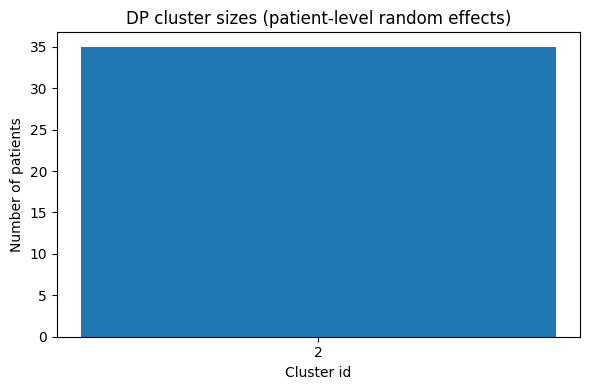

In [30]:
# ---------- 3.3 Cluster size distribution ----------
cluster_sizes_sorted = cluster_sizes.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(range(len(cluster_sizes_sorted)), cluster_sizes_sorted.values)
plt.xticks(range(len(cluster_sizes_sorted)),
           cluster_sizes_sorted.index.astype(str))
plt.xlabel("Cluster id")
plt.ylabel("Number of patients")
plt.title("DP cluster sizes (patient-level random effects)")
plt.tight_layout()
plt.show()


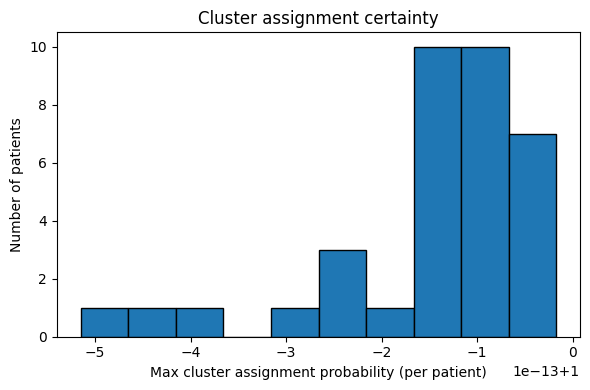

,0
count,35.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [31]:
# ---------- 3.4 Cluster assignment certainty ----------
max_prob = cluster_probs.max(axis=1)

plt.figure(figsize=(6, 4))
plt.hist(max_prob, bins=10, edgecolor="black")
plt.xlabel("Max cluster assignment probability (per patient)")
plt.ylabel("Number of patients")
plt.title("Cluster assignment certainty")
plt.tight_layout()
plt.show()

pd.Series(max_prob).describe().round(3)


In [32]:
# ---------- 3.5 Cluster-level random-effect profiles ----------
required_targets = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
b_df = pd.DataFrame(b_mean, columns=required_targets)
b_df["cluster"] = cluster_id

cluster_profile = b_df.groupby("cluster")[required_targets].mean()
cluster_profile


,PMAX,Glucosio,Trigliceridi,Colesterolo_Hdl,BMI
cluster,,,,,
2,4.792898,4.537287,4.682442,3.99044,3.290788


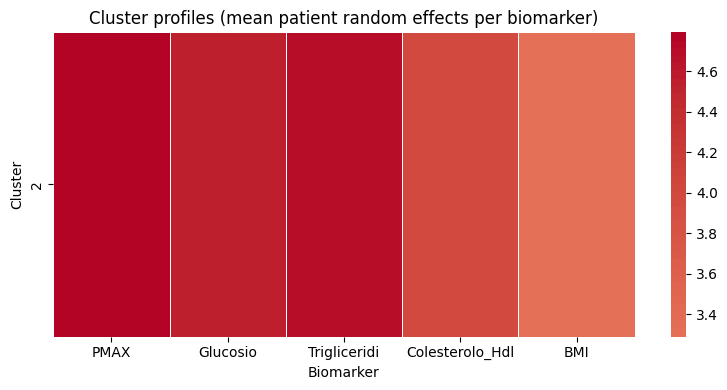

In [33]:
# ---------- 3.6 Heatmap of cluster profiles ----------
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(
    cluster_profile,
    center=0,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Cluster profiles (mean patient random effects per biomarker)")
plt.xlabel("Biomarker")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


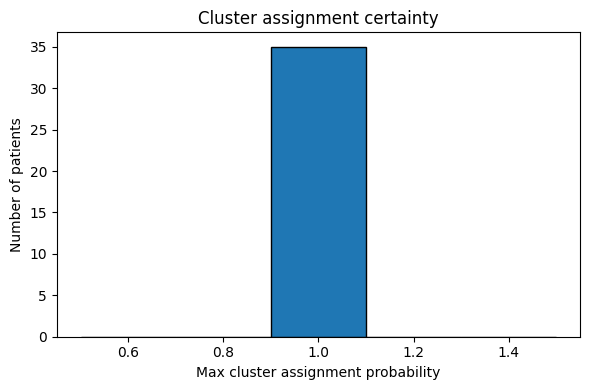

count    35.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
dtype: float64


In [34]:
max_prob = cluster_probs.max(axis=1)

# Round to a reasonable precision
max_prob_rounded = np.round(max_prob, 6)

plt.figure(figsize=(6,4))
plt.hist(max_prob_rounded, bins=5, edgecolor="black")
plt.xlabel("Max cluster assignment probability")
plt.ylabel("Number of patients")
plt.title("Cluster assignment certainty")
plt.tight_layout()
plt.show()

print(pd.Series(max_prob_rounded).describe())
